## LOADING DATA AND LIBRARIES

In [ ]:
!pip install squarify
!pip install catboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
import plotly.express as px
import squarify
%matplotlib inline

In [ ]:
path1 = ("/content/drive/MyDrive/ADMISSIONS.csv")
path2 = ("/content/drive/MyDrive/PATIENTS.csv")
path3 = ("/content/drive/MyDrive/ICUSTAYS.csv")

In [ ]:
df1= pd.read_csv(path1)
df2=pd.read_csv(path2)
df3=pd.read_csv(path3)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Reviewing the patient table
df2.head(5)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


## Exploration Data Analysis

Cleaning the patient table

In [ ]:
#joinging the patient and Admission table together
dfX= pd.merge(df2, df1, how ='left', on ='SUBJECT_ID')

In [ ]:
#veiw the dfx table, The table shows a subject can be admitted more than once as revealed below
dfX.head(5)

,ROW_ID_x,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID_y,HADM_ID,...,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0,321,116935,...,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-12-17 11:10:00,2149-12-17 21:35:00,UNSTABLE ANGINA;ASTHMA;BRONCHITIS,0,1
1,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0,322,149546,...,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,2155-02-03 17:43:00,2155-02-03 21:26:00,GI BLEED/ CHEST PAIN,0,1
2,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0,323,158975,...,Medicare,ENGL,CATHOLIC,DIVORCED,WHITE,NaN,NaN,GI BLEEDING\COLONOSCOPY,0,1
3,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1,324,124271,...,Self Pay,HAIT,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2188-11-12 06:56:00,2188-11-12 10:10:00,PNEUMONIA;R/O TB,1,1
4,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0,325,117937,...,Private,NaN,OTHER,NaN,UNKNOWN/NOT SPECIFIED,2110-07-27 05:00:00,2110-07-27 07:15:00,INTRACRANIAL HEAD BLEED,0,1


In [ ]:
#Dealing with null rows in the dfX table
dfX['LANGUAGE'].fillna(('NA'), inplace = True)
dfX['RELIGION'].fillna(('NA'), inplace = True)
dfX['MARITAL_STATUS'].fillna(('UNKNOWN (DEFAULT)'), inplace = True)
dfX.dropna(subset=['DIAGNOSIS'], inplace = True, axis=0)
dfX.drop(['ROW_ID_x','ROW_ID_y'],axis =1, inplace = True)

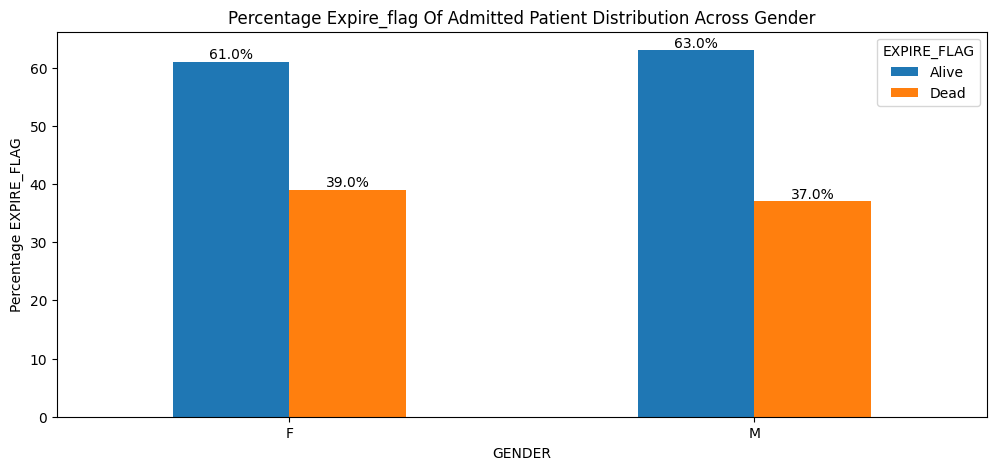

In [ ]:
# computing the percentage numbers of patient(Dead or Alive) acrros their Admission type
dfX_expired = dfX[['SUBJECT_ID', 'EXPIRE_FLAG', 'GENDER']]
dfX_GENDER= dfX_expired.groupby('GENDER')['EXPIRE_FLAG'].value_counts().to_frame().rename(columns={'EXPIRE_FLAG':'count'}).reset_index()
dfX_GENDER['perc'] = [15784/ (15784+10228), 10228/(15784+10228), 20598/ (20598+12341), 12341/ (20598+12341)]
dfX_GENDER['perc'] = dfX_GENDER['perc'] * 100
dfX_GENDER['perc'] = dfX_GENDER['perc'].round()
ax = dfX_GENDER.pivot_table(values='perc', index='GENDER', columns='EXPIRE_FLAG')\
.plot(kind='bar', rot=0, xlabel='GENDER', ylabel='Percentage EXPIRE_FLAG', figsize=(12, 5))
for c in ax.containers:

# Optional: if the segment is small or 0, customize the labels
    labels = [f'{v.get_height()}%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge') # Add percentage labels on the edge of the bars

#plt.title('Percentage Recommendation Distribution Across Seat types')
plt.title('Percentage Expire_flag Of Admitted Patient Distribution Across Gender')
ax.legend(['Alive', 'Dead'], title='EXPIRE_FLAG')

Text(0.5, 1.0, 'Numbers of Admitted Pateint Expired and Their Marital Status ')

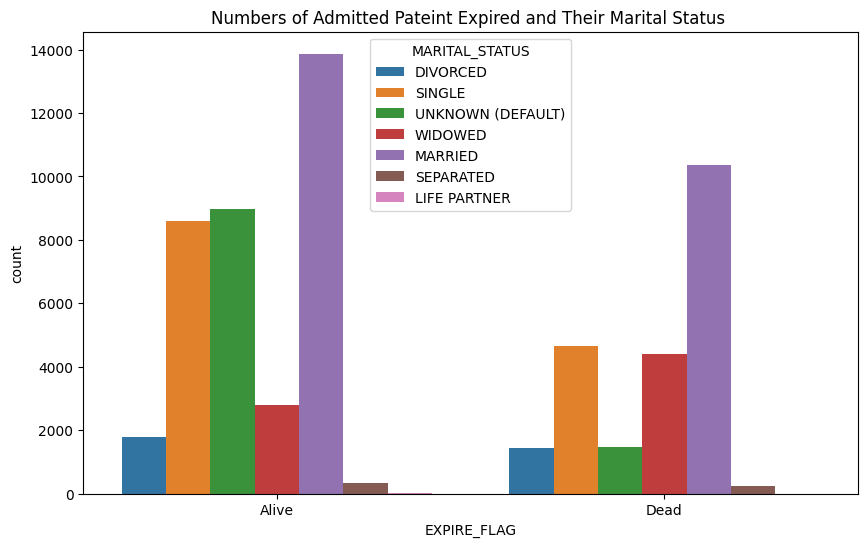

In [ ]:
# computing the  numbers of patient(Dead or Alive) and their marital status
dfX3 =dfX[['SUBJECT_ID', 'EXPIRE_FLAG','GENDER','MARITAL_STATUS']]
plt.figure(figsize=(10,6))
ax  = sns.countplot(data =dfX3, x=dfX3['EXPIRE_FLAG'], hue ='MARITAL_STATUS')

#plt.xticks([0, 1], ['Dead', 'ALIVE'])
ax.set_xticklabels(['Alive', 'Dead'])

plt.title('Numbers of Admitted Pateint Expired and Their Marital Status ')

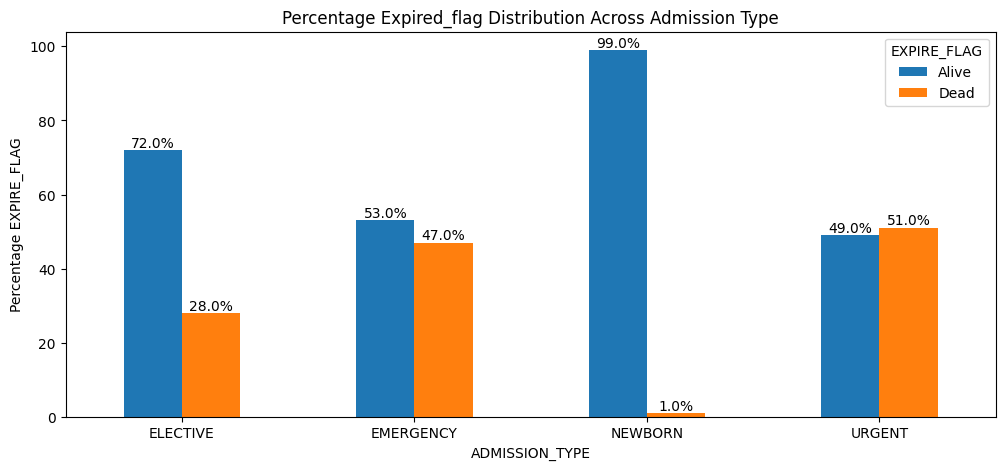

In [ ]:
# computing the percentage numbers of patient(Dead or Alive) accross their Admission type
dfX_expired1 = dfX[['ADMISSION_TYPE', 'EXPIRE_FLAG']]
dfX_ADMISSION_TYPE= dfX_expired1.groupby('ADMISSION_TYPE')['EXPIRE_FLAG'].value_counts().to_frame().rename(columns={'EXPIRE_FLAG':'count'}).reset_index()
dfX_ADMISSION_TYPE['perc'] = [5514/ (5514+2179), 2179/ (5514+2179), 22419/(22419 +19643), 19643/(22419 +19643), 7798/(7798+65), 65/(7798+65),
                              682/(682+651), 651/(682+651)]
dfX_ADMISSION_TYPE['perc'] = dfX_ADMISSION_TYPE['perc'] * 100
dfX_ADMISSION_TYPE['perc'] = dfX_ADMISSION_TYPE['perc'].round()
ax = dfX_ADMISSION_TYPE.pivot_table(values='perc', index='ADMISSION_TYPE', columns='EXPIRE_FLAG')\
.plot(kind='bar', rot=0, xlabel='ADMISSION_TYPE', ylabel='Percentage EXPIRE_FLAG', figsize=(12, 5))
for c in ax.containers:

# Optional: if the segment is small or 0, customize the labels
    labels = [f'{v.get_height()}%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.title('Percentage Expired_flag Distribution Across Admission Type')
ax.legend(['Alive', 'Dead'], title='EXPIRE_FLAG')

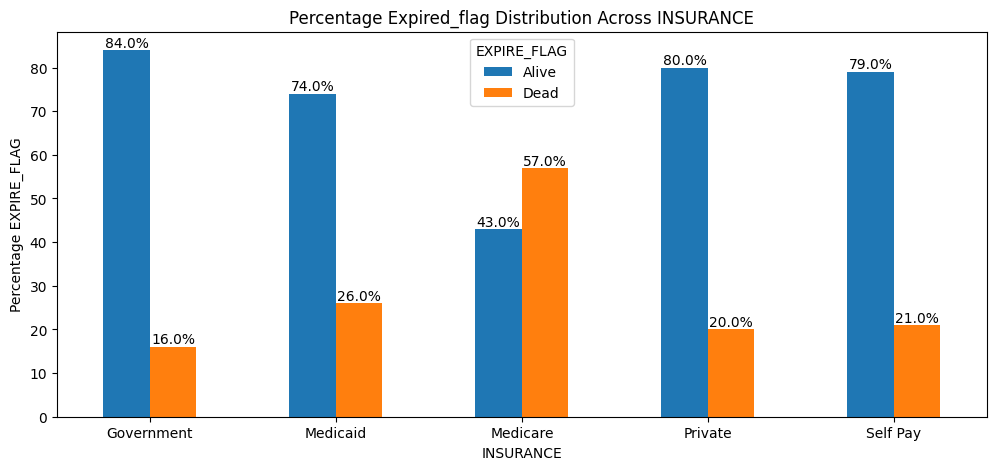

In [ ]:
#computing the percentage numbers of  admitted patient(Dead or Alive) across their  insurance
dfX_expired2 =dfX[['INSURANCE', 'EXPIRE_FLAG']]

dfX_INSURANCE= dfX_expired2.groupby('INSURANCE')['EXPIRE_FLAG'].value_counts().to_frame().rename(columns={'EXPIRE_FLAG':'count'}).reset_index()
dfX_INSURANCE['perc'] = [1491/(1491+ 291), 291/(1491+291), 4270/(4270+1512), 1512/(4270+1512),16017/(16017+12182),
                         12182/(16017+12182), 17957/(17957 +4621), 4621/(17957 +4621),482/(482+128), 128/(482+128)]
dfX_INSURANCE['perc'] = dfX_INSURANCE['perc'] * 100
dfX_INSURANCE['perc'] = dfX_INSURANCE['perc'].round()
ax = dfX_INSURANCE.pivot_table(values='perc', index='INSURANCE', columns='EXPIRE_FLAG')\
.plot(kind='bar',  rot=0, xlabel='INSURANCE', ylabel='Percentage EXPIRE_FLAG', figsize=(12, 5))
for c in ax.containers:

# Optional: if the segment is small or 0, customize the labels
    labels = [f'{v.get_height()}%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

plt.title('Percentage Expired_flag Distribution Across INSURANCE')

ax.legend(['Alive', 'Dead'], title='EXPIRE_FLAG')

Text(0.5, 1.0, 'Diagnosis distribution of most admissions resulting to Survival')

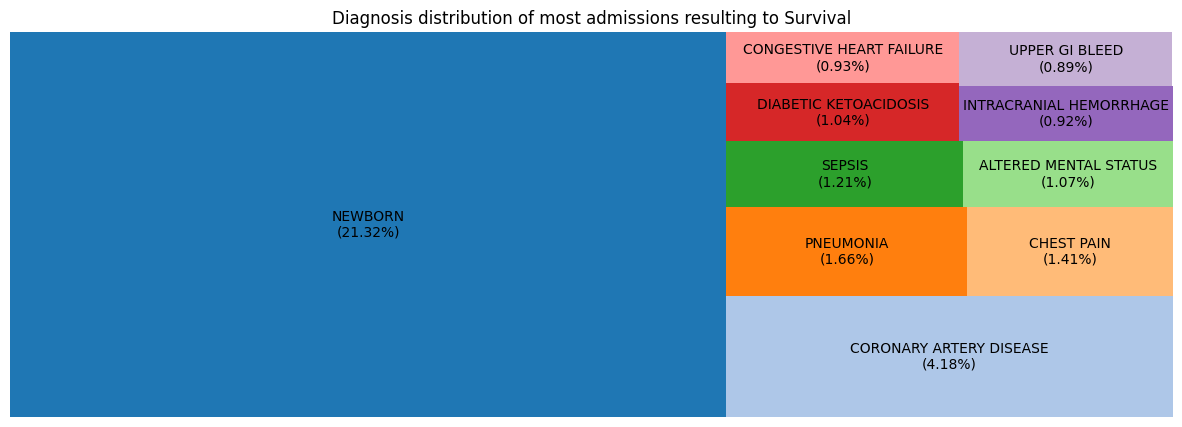

In [ ]:
dfX_DEAD = dfX[dfX['EXPIRE_FLAG']==0]['DIAGNOSIS']
dfX_DEAD.replace('CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA', 'CORONARY ARTERY DISEASE', inplace=True)
dfX_DEAD.replace('CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA', 'CORONARY ARTERY DISEASE', inplace=True)
dfX_DEAD=dfX_DEAD.value_counts().to_frame().reset_index()
dfX_DEAD['Percentage']=(dfX_DEAD['DIAGNOSIS']/dfX_DEAD['DIAGNOSIS'].sum() ) * 100
dfX_DEAD.sort_values('Percentage', inplace=True, ascending=False)
dfX_DEAD=dfX_DEAD.head(10).round(2)
dfX_DEAD['label']= dfX_DEAD['index'] + '\n'+ '(' + dfX_DEAD['Percentage'].astype(str)+ '%)'
values=dfX_DEAD['DIAGNOSIS'].to_list()
labels=dfX_DEAD['label'].to_list()
plt.figure(figsize=(15, 5))
squarify.plot(sizes = values, label = labels, color=sns.color_palette("tab20", len(values)))
# Remove the axis:
plt.axis("off")
plt.title('Diagnosis distribution of most admissions resulting to Survival')

Text(0.5, 1.0, 'Diagnosis distribution of most admissions resulting to Death')

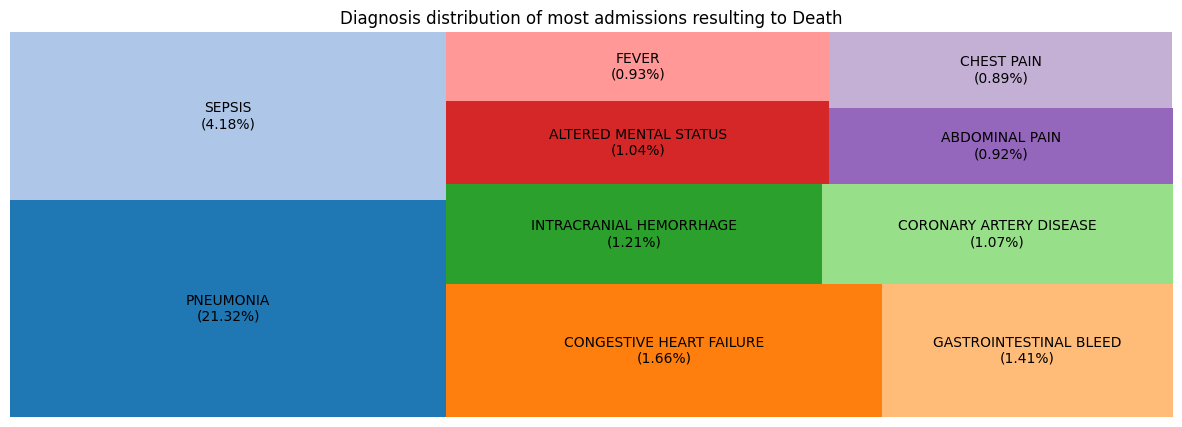

In [ ]:
dfX_ALIVE = dfX[dfX['EXPIRE_FLAG']==1]['DIAGNOSIS']
dfX_ALIVE.replace('CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA', 'CORONARY ARTERY DISEASE', inplace=True)
dfX_ALIVE.replace('CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA', 'CORONARY ARTERY DISEASE', inplace=True)
dfX_ALIVE=dfX_ALIVE.value_counts().to_frame().reset_index()
dfX_ALIVE['Percentage']=(dfX_ALIVE['DIAGNOSIS']/dfX_ALIVE['DIAGNOSIS'].sum() ) * 100
dfX_ALIVE.sort_values('Percentage', inplace=True, ascending=False)
dfX_ALIVE=dfX_ALIVE.head(10).round(2)
dfX_ALIVE['label']= dfX_ALIVE['index'] + '\n'+ '(' + dfX_DEAD['Percentage'].astype(str)+ '%)'
values=dfX_ALIVE['DIAGNOSIS'].to_list()
labels=dfX_ALIVE['label'].to_list()
plt.figure(figsize=(15, 5))
squarify.plot(sizes = values, label = labels, color=sns.color_palette("tab20", len(values)))
# Remove the axis:
plt.axis("off")
plt.title('Diagnosis distribution of most admissions resulting to Death')

In [ ]:
#joining the dfX(PATIENT & ADMISSION table) with the ICU table, we join them on the SUJECT_ID and ADMISSION_ID
dfY = pd.merge(dfX, df3, how ='left', on=('HADM_ID', 'SUBJECT_ID'))

In [ ]:
dfY.dropna(subset=['ICUSTAY_ID'],inplace =True, axis = 0) #Removing the null rows on the ICUSTAY_ID
dfY['LOS'].fillna(dfY['LOS'].mean(), inplace = True) #replacing  null in the LOS column with mean

Text(0.5, 1.0, 'NUMBER OF PATEINT EXPIRED AND THEIR FIRST_CAREUNIT ')

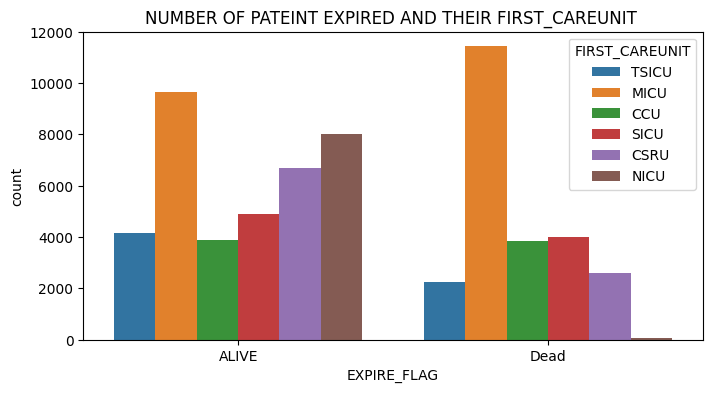

In [ ]:
# computing the numbers of admiited patient(Dead or Alive) in the ICU and their  first careunit
plt.figure(figsize=(8,4))
sns.countplot(data = dfY, x=dfY['EXPIRE_FLAG'], hue ='FIRST_CAREUNIT')
plt.xticks([1, 0], ['Dead', 'ALIVE'])
plt.title('NUMBER OF PATEINT EXPIRED AND THEIR FIRST_CAREUNIT ')

Text(0.5, 1.0, 'NUMBER OF PATEINT EXPIRED AND THEIR LAST_CAREUNIT ')

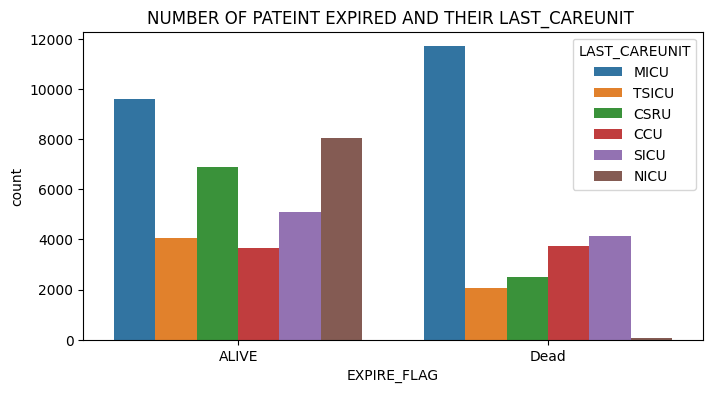

In [ ]:
# computing the numbers of admiited patient(Dead or Alive) in the ICU and their  last careunit

plt.figure(figsize=(8,4))
sns.countplot(data = dfY, x=dfY['EXPIRE_FLAG'], hue ='LAST_CAREUNIT')
plt.xticks([1, 0], ['Dead', 'ALIVE'])
plt.title('NUMBER OF PATEINT EXPIRED AND THEIR LAST_CAREUNIT ')

([<matplotlib.axis.XTick at 0x7ffadc04f310>,
 [Text(0, 0, "DIDN'T CHANGE UNITS"), Text(1, 0, 'CHANGED UNITS')])

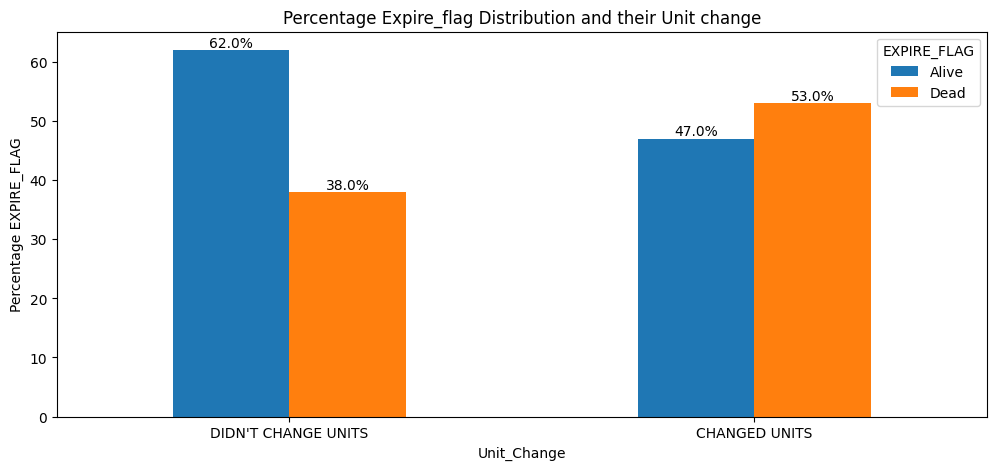

In [ ]:
#computing the percentage unit change for admitted patient that is dead or alive

dfY['Unit_Change'] = np.where(dfY[ 'FIRST_CAREUNIT']==dfY['LAST_CAREUNIT'], 0, 1) # 0 means false, 1 means true
dfY_UNITCHANGE = dfY[['Unit_Change','EXPIRE_FLAG']]
dfY_exUnitchange = dfY_UNITCHANGE.groupby('Unit_Change')['EXPIRE_FLAG'].value_counts().to_frame().rename(columns={'EXPIRE_FLAG':'count'}).reset_index()
dfY_exUnitchange['perc'] = [35536/ (35536+ 22162), 22162/ (35536+ 22162), 2028/(2028+1805), 1805/(2028+1805)]
dfY_exUnitchange['perc'] = dfY_exUnitchange['perc'] * 100
dfY_exUnitchange['perc'] = dfY_exUnitchange['perc'].round()
ax = dfY_exUnitchange.pivot_table(values='perc', index='Unit_Change', columns='EXPIRE_FLAG')\
.plot(kind='bar', rot=0, xlabel='Unit_Change', ylabel='Percentage EXPIRE_FLAG', figsize=(12, 5))
for c in ax.containers:

# Optional: if the segment is small or 0, customize the labels
    labels = [f'{v.get_height()}%' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge') # Add percentage labels on the edge of the bars

plt.title('Percentage Expire_flag Distribution and their Unit change')
ax.legend(['Alive', 'Dead'], title='EXPIRE_FLAG')
plt.xticks([0, 1], ["DIDN'T CHANGE UNITS", 'CHANGED UNITS'])

Text(0.5, 1.0, 'Gender Distribution of total Admitted patients in the ICU')

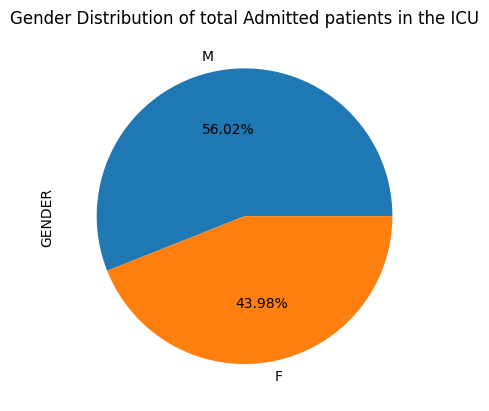

In [ ]:
#computing the gender distribution of the total admitted patients(dead and alive) in the ICU
dfY['GENDER'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.title('Gender Distribution of total Admitted patients in the ICU')

Text(0.5, 1.0, 'Survival Distribution of total Admitted patients in the ICU')

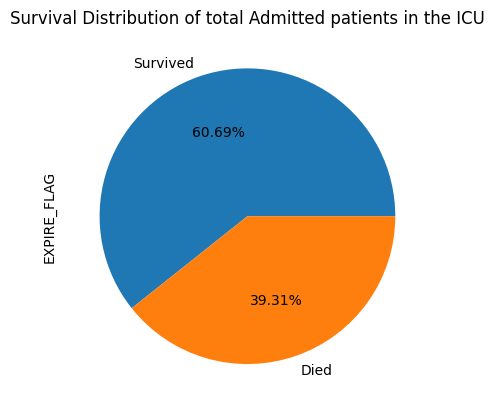

In [ ]:
#computing the surivial distribution of the total admitted patients in the ICU
dfY['EXPIRE_FLAG'].map({1:'Died', 0:'Survived'}).value_counts().plot(kind='pie', autopct='%.2f%%')
plt.title('Survival Distribution of total Admitted patients in the ICU')

## MACHINE LEARNING SECTION

In [ ]:
#coverting the date column to datetime datatypes
dfY['DOB']=pd.to_datetime(dfY['DOB'])
dfY['ADMITTIME'] =pd.to_datetime(dfY['ADMITTIME'])
dfY['YOB']=dfY['DOB'].dt.year
dfY['YOA']=dfY['ADMITTIME'].dt.year
dfY['AGE']= dfY['YOA']- dfY['YOB']

In [ ]:
#removing the rows and columns that are not needed for the machine learning model
dfY.dropna(subset = ['FIRST_CAREUNIT'], axis = 0, inplace=True)
dfY.drop(['INTIME','OUTTIME','ICUSTAY_ID','ROW_ID','HADM_ID'], axis=1,inplace = True)
dfY.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','EDREGTIME','EDOUTTIME','DEATHTIME','ADMITTIME'], axis=1,inplace = True)
dfY.drop(['DOD','DOD_HOSP','DOD_SSN'], axis=1,inplace = True)
dfY.drop(['DOB'], axis=1,inplace = True)
dfY.drop(['DISCHTIME'], axis=1,inplace = True)
dfY.drop(['DISCHARGE_LOCATION'], axis=1,inplace = True)
dfY.drop(['LAST_WARDID','FIRST_WARDID'], axis=1,inplace = True)

In [ ]:
import os
os.mkdir('Pickles')

In [ ]:
#encoding the gategorical column to a number using label enconder
import pickle
from sklearn.preprocessing import LabelEncoder
LabelEncoder = LabelEncoder()
dfY['GENDER']= LabelEncoder.fit_transform(dfY['GENDER'])
output = open('/content/Pickles/gender.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['ADMISSION_TYPE']= LabelEncoder.fit_transform(dfY['ADMISSION_TYPE'])
output = open('/content/Pickles/admission.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['RELIGION']= LabelEncoder.fit_transform(dfY['RELIGION'])
output = open('/content/Pickles/religion.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['INSURANCE']= LabelEncoder.fit_transform(dfY['INSURANCE'])
output = open('/content/Pickles/insurance.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['LANGUAGE']= LabelEncoder.fit_transform(dfY['LANGUAGE'])
output = open('/content/Pickles/langauage.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['MARITAL_STATUS']= LabelEncoder.fit_transform(dfY['MARITAL_STATUS'])
output = open('/content/Pickles/status.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['ETHNICITY']= LabelEncoder.fit_transform(dfY['ETHNICITY'])
output = open('/content/Pickles/eth.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['DIAGNOSIS']= LabelEncoder.fit_transform(dfY['DIAGNOSIS'])
output = open('/content/Pickles/diag.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['DBSOURCE']= LabelEncoder.fit_transform(dfY['DBSOURCE'])
output = open('/content/Pickles/dbs.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['FIRST_CAREUNIT']= LabelEncoder.fit_transform(dfY['FIRST_CAREUNIT']) #FIRST_CAREUNIT
output = open('/content/Pickles/fc.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['LAST_CAREUNIT']= LabelEncoder.fit_transform(dfY['LAST_CAREUNIT'])
output = open('/content/Pickles/lc.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()
dfY['ADMISSION_LOCATION']= LabelEncoder.fit_transform(dfY['ADMISSION_LOCATION'])
output = open('adm_loc.pkl', 'wb')
pickle.dump(LabelEncoder, output)
output.close()

In [ ]:
dfY.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61531 entries, 0 to 62696
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GENDER                61531 non-null  int64  
 1   EXPIRE_FLAG           61531 non-null  int64  
 2   ADMISSION_TYPE        61531 non-null  int64  
 3   ADMISSION_LOCATION    61531 non-null  int64  
 4   INSURANCE             61531 non-null  int64  
 5   LANGUAGE              61531 non-null  int64  
 6   RELIGION              61531 non-null  int64  
 7   MARITAL_STATUS        61531 non-null  int64  
 8   ETHNICITY             61531 non-null  int64  
 9   DIAGNOSIS             61531 non-null  int64  
 10  HAS_CHARTEVENTS_DATA  61531 non-null  int64  
 11  DBSOURCE              61531 non-null  int64  
 12  FIRST_CAREUNIT        61531 non-null  int64  
 13  LAST_CAREUNIT         61531 non-null  int64  
 14  LOS                   61531 non-null  float64
 15  Unit_Change        

In [ ]:
#setting the X and Y for the machine model
X= dfY.drop('EXPIRE_FLAG', axis=1)
y= dfY['EXPIRE_FLAG']

In [ ]:
#spilting the table into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [ ]:
#feature scaling, so that they will be on the same scale
from sklearn.preprocessing import StandardScaler
sc_X= StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
scalerfile = 'scaler.sav'
from sklearn.preprocessing import StandardScaler
sc_X= StandardScaler()
X= sc_X.fit_transform(X)
pickle.dump(sc_X, open(scalerfile, 'wb'))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X,y)
# import joblib
# joblib.dump(classifier, "classifier.joblib", 9)

RandomForestClassifier()

In [ ]:
x= dfY[dfY['EXPIRE_FLAG']==0].drop('EXPIRE_FLAG', axis=1).loc[632].to_list()
x=np.array(x).reshape(1,-1)
X=sc_X.transform(x)
print(classifier.predict(X))
print(classifier.predict_proba(X))

[0]
[[0.88 0.12]]


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier1=LogisticRegression()
classifier1.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
y_pred = classifier1.predict(X_test)
f1_score(y_test, y_pred)

0.5312287847929396

In [ ]:
roc_auc_score(y_test, classifier1.predict_proba(X_test)[:, 1])

0.7641824791271978

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78     11204
           1       0.69      0.43      0.53      7256

    accuracy                           0.70     18460
   macro avg       0.70      0.65      0.66     18460
weighted avg       0.70      0.70      0.68     18460



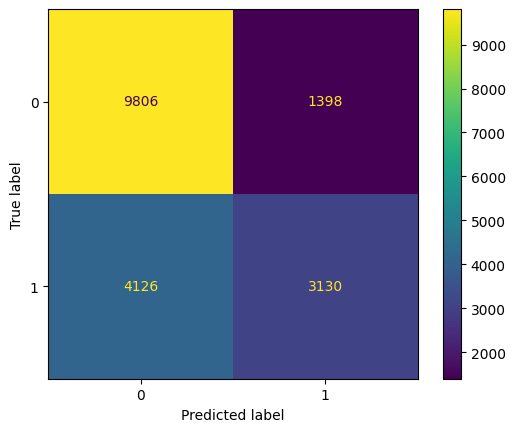

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=classifier1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier1.classes_)
disp.plot()
plt.show()

In [ ]:
coef=pd.DataFrame(classifier1.coef_)
coef.columns = X.columns
coef.T.reset_index()

,index,0
0,GENDER,0.007656
1,ADMISSION_TYPE,-0.055034
2,ADMISSION_LOCATION,-0.111397
3,INSURANCE,-0.205831
4,LANGUAGE,0.158436
5,RELIGION,-0.079400
6,MARITAL_STATUS,-0.117369
7,ETHNICITY,0.088183
8,DIAGNOSIS,0.035650
9,HAS_CHARTEVENTS_DATA,-0.066774


Support Vector Machine

In [ ]:
from sklearn.svm import SVC
classifier2 = SVC(kernel= 'rbf',random_state=0, probability=True)
classifier2.fit(X_train,y_train)
y_pred2 = classifier2.predict(X_test)
f1_score(y_test, y_pred2)

0.6504926843833981

In [ ]:
roc_auc_score(y_test, classifier2.predict_proba(X_test)[:, 1])

0.8144924418629824

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80     11204
           1       0.71      0.60      0.65      7256

    accuracy                           0.75     18460
   macro avg       0.74      0.72      0.73     18460
weighted avg       0.74      0.75      0.74     18460



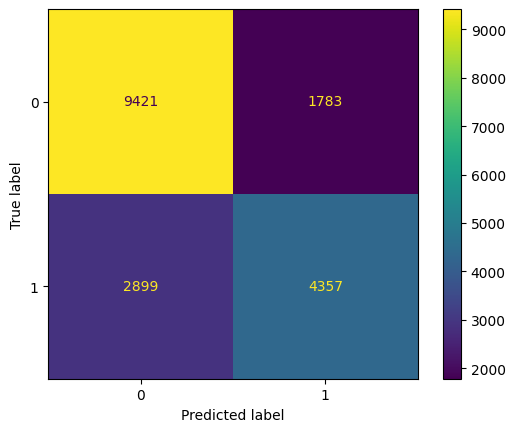

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred2, labels=classifier2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier2.classes_)
disp.plot()
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier3 = RandomForestClassifier()
classifier3.fit(X_train, y_train)
y_pred3 = classifier3.predict(X_test)
f1_score(y_test, y_pred3)

0.7136337706788363

In [ ]:
roc_auc_score(y_test, classifier3.predict_proba(X_test)[:, 1])

0.8609333626614688

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82     11204
           1       0.74      0.69      0.71      7256

    accuracy                           0.78     18460
   macro avg       0.77      0.77      0.77     18460
weighted avg       0.78      0.78      0.78     18460



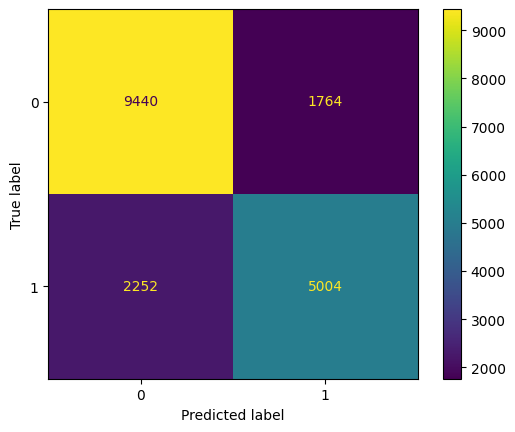

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred3, labels=classifier3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier3.classes_)
disp.plot()
plt.show()

Text(0.5, 0, 'Relative Importance')

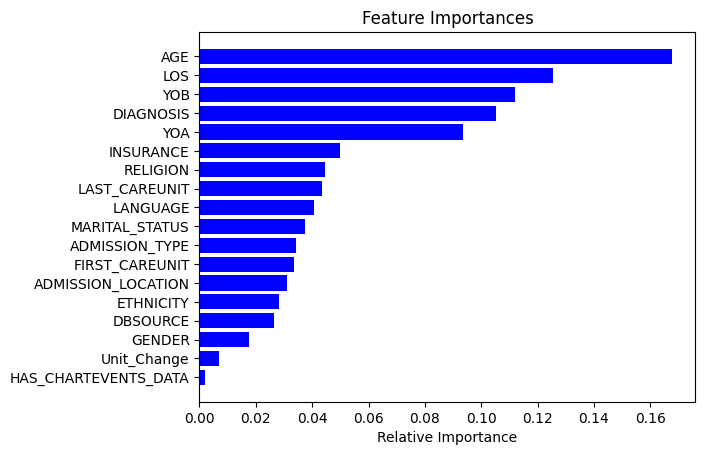

In [ ]:
# random Forest Feature importance
features=X.columns
importances = classifier3.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

Catboost

In [ ]:
from catboost import CatBoostClassifier
classifier4 = CatBoostClassifier(verbose=0)
classifier4.fit(X_train, y_train)
y_pred4 = classifier4.predict(X_test)
f1_score(y_test, y_pred4)

0.699607843137255

In [ ]:
roc_auc_score(y_test, classifier4.predict_proba(X_test)[:, 1])

0.8525688228766936

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     11204
           1       0.72      0.68      0.70      7256

    accuracy                           0.77     18460
   macro avg       0.76      0.75      0.76     18460
weighted avg       0.77      0.77      0.77     18460



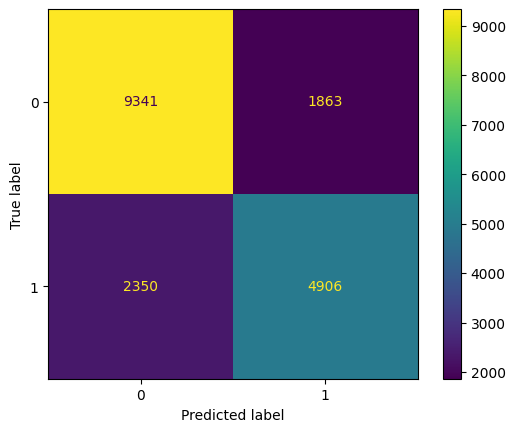

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred4, labels=classifier4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier4.classes_)
disp.plot()
plt.show()

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier5 = DecisionTreeClassifier()
classifier5.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
y_pred5= classifier5.predict(X_test)
f1_score(y_test,y_pred5)

0.6211841835689408

In [ ]:
roc_auc_score(y_test, classifier5.predict_proba(X_test)[:, 1])

0.6866999874434512

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     11204
           1       0.62      0.63      0.62      7256

    accuracy                           0.70     18460
   macro avg       0.69      0.69      0.69     18460
weighted avg       0.70      0.70      0.70     18460



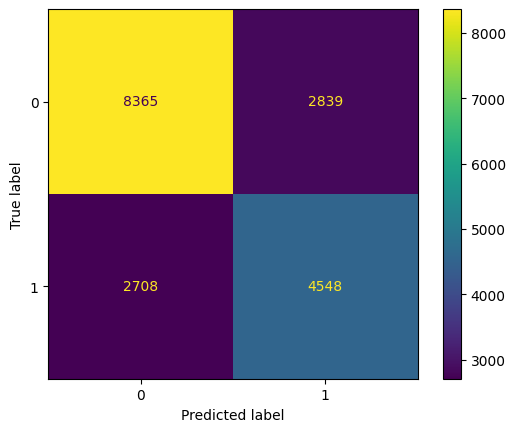

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred5, labels=classifier5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier5.classes_)
disp.plot()
plt.show()